<a href="https://colab.research.google.com/github/George-Okello/Ambiguity/blob/main/Ambiguity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install HuggingFace Transformers and Datasets libraries
!pip install transformers datasets -q


In [ ]:
import random
from datasets import load_dataset
import numpy as np
import torch
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True  # less efficient but reproducible
    torch.backends.cudnn.benchmark = False

set_seed(42)
# Load the WSC dataset
dataset = load_dataset("super_glue", "wsc.fixed")
dataset = dataset["validation"]  # Using the validation set for testing


In [ ]:
# View a sample
sample = dataset[0]
for k, v in sample.items():
    print(f"{k}: {v}")


text: Bernard , who had not told the government official that he was less than 21 when he filed for a homestead claim, did not consider that he had done anything dishonest. Still, anyone who knew that he was 19 years old could take his claim away from him .
span1_index: 32
span2_index: 47
span1_text: anyone
span2_text: him
idx: 0
label: 0


In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")
model.eval()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
from torch.nn.functional import softmax

def score_sentence(sentence, target):
    # Tokenize and locate the token span
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    # Get score for entire sentence (log prob of each token)
    input_ids = inputs.input_ids[0]
    log_probs = softmax(logits[0], dim=-1)
    token_probs = [log_probs[i, input_ids[i]].item() for i in range(len(input_ids))]
    return sum(torch.log(torch.tensor(token_probs))).item()


In [ ]:
text = sample["text"]
span1 = sample["span1_text"]
span2 = sample["span2_text"]

# Replace ambiguous pronoun with noun
text_with_sub = text.replace(span1, span2)

# Score both
original_score = score_sentence(text, span1)
sub_score = score_sentence(text_with_sub, span2)

print(f"Original: {text}")
print(f"Modified: {text_with_sub}")
print(f"Score with pronoun: {original_score:.2f}")
print(f"Score with candidate: {sub_score:.2f}")

# Prediction
prediction = int(sub_score > original_score)
print(f"Predicted label: {prediction}, True label: {sample['label']}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Original: Bernard , who had not told the government official that he was less than 21 when he filed for a homestead claim, did not consider that he had done anything dishonest. Still, anyone who knew that he was 19 years old could take his claim away from him .
Modified: Bernard , who had not told the government official that he was less than 21 when he filed for a homestead claim, did not consider that he had done anything dishonest. Still, him who knew that he was 19 years old could take his claim away from him .
Score with pronoun: -41.93
Score with candidate: -43.39
Predicted label: 0, True label: 0


In [ ]:
correct = 0

for i in range(len(dataset)):
    ex = dataset[i]
    if ex['span1_text'] not in ex['text']:
        continue  # Skip malformed entries
    text = ex['text']
    span1 = ex['span1_text']
    span2 = ex['span2_text']
    label = ex['label']

    try:
        text_with_sub = text.replace(span1, span2)
        original_score = score_sentence(text, span1)
        sub_score = score_sentence(text_with_sub, span2)
        prediction = int(sub_score > original_score)
        correct += (prediction == label)
    except:
        continue

accuracy = correct / len(dataset)
print(f"\n📊 Accuracy: {accuracy * 100:.2f}%")



📊 Accuracy: 58.65%


Evaluate RoBERTa

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch
from torch.nn.functional import softmax
from datasets import load_dataset

# Load model
roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-large")
roberta_model = AutoModelForMaskedLM.from_pretrained("roberta-large").eval()

# Load WSC data
wsc = load_dataset("super_glue", "wsc.fixed")["validation"]


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [ ]:
def roberta_score_sentence(sentence):
    inputs = roberta_tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        logits = roberta_model(**inputs).logits
    input_ids = inputs.input_ids[0]
    probs = softmax(logits[0], dim=-1)
    token_probs = [probs[i, input_ids[i]].item() for i in range(len(input_ids))]
    return sum(torch.log(torch.tensor(token_probs))).item()


In [ ]:
correct = 0
total = 0

for ex in wsc:
    try:
        t = ex['text']
        span1 = ex['span1_text']
        span2 = ex['span2_text']
        if span1 not in t or span2 not in t:
            continue
        modified = t.replace(span2, span1)
        orig_score = roberta_score_sentence(t)
        mod_score = roberta_score_sentence(modified)
        pred = int(mod_score > orig_score)
        if pred == ex['label']:
            correct += 1
        total += 1
    except Exception:
        continue

print(f"📊 RoBERTa Accuracy: {correct / total * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


📊 RoBERTa Accuracy: 57.69%


In [ ]:
def masked_fill(sentence, masked_word):
    masked = sentence.replace(masked_word, roberta_tokenizer.mask_token)
    inputs = roberta_tokenizer(masked, return_tensors="pt")
    with torch.no_grad():
        logits = roberta_model(**inputs).logits
    mask_token_index = (inputs.input_ids == roberta_tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
    predicted_ids = logits[0, mask_token_index].topk(5).indices[0].tolist()
    return [roberta_tokenizer.decode([idx]).strip() for idx in predicted_ids]


In [ ]:
example = wsc[0]
masked_fill(example["text"], example["span2_text"])


['him', 'Bernard', 'his', 'them', 'her']

Evaluate DeBERTa

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch
from torch.nn.functional import softmax
from datasets import load_dataset

# Load model
deberta_tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
deberta_model = AutoModelForMaskedLM.from_pretrained("microsoft/deberta-v3-base")

# Load WSC data
wsc = load_dataset("super_glue", "wsc.fixed")["validation"]


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForMaskedLM were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def deberta_score_sentence(sentence):
    inputs = deberta_tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        logits = deberta_model(**inputs).logits
    input_ids = inputs.input_ids[0]
    probs = softmax(logits[0], dim=-1)
    token_probs = [probs[i, input_ids[i]].item() for i in range(len(input_ids))]
    return sum(torch.log(torch.tensor(token_probs))).item()

In [ ]:
correct = 0
total = 0

for ex in wsc:
    try:
        t = ex['text']
        span1 = ex['span1_text']
        span2 = ex['span2_text']
        if span1 not in t or span2 not in t:
            continue
        modified = t.replace(span2, span1)
        orig_score = deberta_score_sentence(t)
        mod_score = deberta_score_sentence(modified)
        pred = int(mod_score > orig_score)
        if pred == ex['label']:
            correct += 1
        total += 1
    except Exception:
        continue

print(f"📊 DeBERTa Accuracy: {correct / total * 100:.2f}%")


📊 DeBERTa Accuracy: 59.62%


In [ ]:
example = wsc[0]
masked_fill(example["text"], example["span2_text"])

['him', 'Bernard', 'his', 'them', 'her']

Use [MASK] Token to Probe Language Understanding

In [ ]:
def get_mask_predictions(sentence, target_word, model, tokenizer, top_k=5):
    # Replace the target word with the model's mask token
    if target_word not in sentence:
        raise ValueError("Target word not in sentence.")

    masked_sentence = sentence.replace(target_word, tokenizer.mask_token, 1)
    inputs = tokenizer(masked_sentence, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs).logits

    mask_token_index = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
    top_k_ids = outputs[0, mask_token_index].topk(top_k, dim=-1).indices[0].tolist()
    predictions = [tokenizer.decode([idx]).strip() for idx in top_k_ids]

    return masked_sentence, predictions


In [ ]:
sample = wsc[0]  # Use the first WSC example
sentence = sample["text"]
target = sample["span2_text"]

masked, guesses = get_mask_predictions(sentence, target, roberta_model, roberta_tokenizer)
print("Masked sentence:", masked)
print("Top predictions:", guesses)


Masked sentence: Bernard , who had not told the government official that he was less than 21 when he filed for a homestead claim, did not consider that he had done anything dishonest. Still, anyone who knew that he was 19 years old could take his claim away from <mask> .
Top predictions: ['him', 'Bernard', 'his', 'them', 'her']


DeBERTa is better at reasoning about relationships between entities, while RoBERTa is better at predicting what words should appear in contex

Fine-Tuning BERT on WSC (Binary Classification

In [ ]:
!pip install transformers datasets

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import os


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
from datasets import load_dataset

dataset = load_dataset("super_glue", "wsc")
train_data = dataset['train']
val_data = dataset['validation']


wsc/train-00000-of-00001.parquet:   0%|          | 0.00/27.2k [00:00<?, ?B/s]

wsc/validation-00000-of-00001.parquet:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

wsc/test-00000-of-00001.parquet:   0%|          | 0.00/12.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/554 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/104 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/146 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-base')
special_tokens = ['<s1>', '</s1>', '<s2>', '</s2>']
tokenizer.add_tokens(special_tokens)

4

In [ ]:
from transformers import AutoModel

class WSCDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        sentence = example['text']
        span1 = example['span1_text']
        span2 = example['span2_text']
        label = example['label']

        # Add special tokens to help model recognize spans
        marked_sentence = sentence.replace(span1, f"<s1>{span1}</s1>")
        marked_sentence = marked_sentence.replace(span2, f"<s2>{span2}</s2>")

        # Tokenize
        encoding = self.tokenizer(
            marked_sentence,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
class WSCClassifier(nn.Module):
    def __init__(self, tokenizer_len):
        super().__init__()
        self.deberta = AutoModel.from_pretrained('microsoft/deberta-v3-base')
        # Resize embeddings for new special tokens
        self.deberta.resize_token_embeddings(tokenizer_len)
        self.classifier = nn.Linear(self.deberta.config.hidden_size, 2)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        # Use [CLS] token (position 0) for classification
        cls_token = outputs.last_hidden_state[:, 0, :]
        cls_token = self.dropout(cls_token)
        return self.classifier(cls_token)

In [ ]:
train_dataset = WSCDataset(train_data, tokenizer)
val_dataset = WSCDataset(val_data, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Clear CUDA cache
import torch
torch.cuda.empty_cache()

In [ ]:
class WSCClassifier(nn.Module):
    def __init__(self, vocab_size=None):  # Add parameter if needed
        super().__init__()
        self.deberta = AutoModel.from_pretrained('microsoft/deberta-v3-base')

        # Resize embeddings if vocab_size is provided
        if vocab_size:
            self.deberta.resize_token_embeddings(vocab_size)

        self.classifier = nn.Linear(self.deberta.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs.last_hidden_state[:, 0, :]
        return self.classifier(cls_token)

In [ ]:
model = WSCClassifier().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
EPOCHS = 4

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()

    acc = correct / len(train_loader.dataset)
    print(f"Epoch {epoch+1} | Train Loss: {total_loss:.4f} | Train Acc: {acc*100:.2f}%")

100%|██████████| 70/70 [00:33<00:00,  2.10it/s]


Epoch 1 | Train Loss: 49.1191 | Train Acc: 50.00%


100%|██████████| 70/70 [00:28<00:00,  2.47it/s]


Epoch 2 | Train Loss: 48.8857 | Train Acc: 49.28%


100%|██████████| 70/70 [00:22<00:00,  3.13it/s]


Epoch 3 | Train Loss: 49.1703 | Train Acc: 50.36%


100%|██████████| 70/70 [00:22<00:00,  3.06it/s]

Epoch 4 | Train Loss: 48.6522 | Train Acc: 50.54%


In [ ]:
model.eval()
correct = 0

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        logits = model(input_ids, attention_mask)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()

val_acc = correct / len(val_loader.dataset)
print(f"✅ Validation Accuracy: {val_acc*100:.2f}%")


✅ Validation Accuracy: 63.46%


Span-Aware Fine-Tuning

In [ ]:
!pip install transformers tqdm --quiet


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


In [ ]:
class SpanAwareWSCDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        sentence = example['text']
        span1 = example['span1_text']
        span2 = example['span2_text']
        label = example['label']

        encoding = self.tokenizer(
            sentence,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt',
            return_offsets_mapping=True
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        offset_mapping = encoding['offset_mapping'].squeeze()

        span1_mask = torch.zeros_like(input_ids)
        span2_mask = torch.zeros_like(input_ids)

        span1_start = sentence.find(span1)
        span1_end = span1_start + len(span1)
        span2_start = sentence.find(span2)
        span2_end = span2_start + len(span2)

        for i, (start, end) in enumerate(offset_mapping):
            if start == 0 and end == 0:
                continue

            if not (end <= span1_start or start >= span1_end):
                span1_mask[i] = 1

            if not (end <= span2_start or start >= span2_end):
                span2_mask[i] = 1

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'span1_mask': span1_mask,
            'span2_mask': span2_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }


This model uses DeBERTa as a base encoder and adds:
- Multi-head attention over each span
- Cross-attention between the two spans
- A classifier over the combined representations of `[CLS]`, span1, span2, and their interaction


In [ ]:
class SpanAwareWSCClassifier(nn.Module):
    def __init__(self, model_name='microsoft/deberta-v3-base', hidden_size=768):
        super().__init__()
        self.deberta = AutoModel.from_pretrained(model_name)
        self.hidden_size = hidden_size

        self.span1_attention = nn.MultiheadAttention(hidden_size, 8, batch_first=True)
        self.span2_attention = nn.MultiheadAttention(hidden_size, 8, batch_first=True)
        self.cross_attention = nn.MultiheadAttention(hidden_size, 8, batch_first=True)

        self.dropout = nn.Dropout(0.1)
        self.layer_norm = nn.LayerNorm(hidden_size * 4)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 4, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, 2)
        )

    def forward(self, input_ids, attention_mask, span1_mask, span2_mask):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        cls_repr = hidden_states[:, 0, :]

        span1_repr = self.get_span_representation(hidden_states, span1_mask, self.span1_attention)
        span2_repr = self.get_span_representation(hidden_states, span2_mask, self.span2_attention)
        interaction_repr = self.get_interaction_representation(span1_repr, span2_repr)

        combined = torch.cat([cls_repr, span1_repr, span2_repr, interaction_repr], dim=-1)
        combined = self.layer_norm(combined)
        combined = self.dropout(combined)
        return self.classifier(combined)

    def get_span_representation(self, hidden_states, span_mask, attention_layer, return_attention=False):
        batch_size, seq_len, hidden_size = hidden_states.size()
        span_attention_mask = span_mask.float()
        has_span = span_attention_mask.sum(dim=1, keepdim=True) > 0

        attn_output, attn_weights = attention_layer(
            hidden_states,
            hidden_states,
            hidden_states,
            key_padding_mask=(1 - span_attention_mask).bool(),
            need_weights=True,
            average_attn_weights=True
        )

        span_lengths = span_attention_mask.sum(dim=1, keepdim=True).clamp(min=1)
        span_repr = (attn_output * span_attention_mask.unsqueeze(-1)).sum(dim=1) / span_lengths
        cls_repr = hidden_states[:, 0, :]
        final_repr = torch.where(has_span, span_repr, cls_repr)

        if return_attention:
            return final_repr, attn_weights
        return final_repr

    def get_interaction_representation(self, span1_repr, span2_repr):
        interaction, _ = self.cross_attention(
            span1_repr.unsqueeze(1),
            span2_repr.unsqueeze(1),
            span2_repr.unsqueeze(1)
        )
        return interaction.squeeze(1)


This function handles the full training loop including:
- Data loading
- Accuracy and loss tracking
- Learning rate scheduling
- Model checkpointing


In [ ]:
def train_span_aware_model(train_data, val_data, tokenizer, device, epochs=10, patience=3):
    train_dataset = SpanAwareWSCDataset(train_data, tokenizer)
    val_dataset = SpanAwareWSCDataset(val_data, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8)

    model = SpanAwareWSCClassifier().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=epochs)
    criterion = nn.CrossEntropyLoss()

    print(f"🚀 Model has {sum(p.numel() for p in model.parameters()):,} parameters")

    best_val_acc = 0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            span1_mask = batch['span1_mask'].to(device)
            span2_mask = batch['span2_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            logits = model(input_ids, attention_mask, span1_mask, span2_mask)
            loss = criterion(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        val_loss, val_correct, val_total = 0, 0, 0
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                span1_mask = batch['span1_mask'].to(device)
                span2_mask = batch['span2_mask'].to(device)
                labels = batch['label'].to(device)

                logits = model(input_ids, attention_mask, span1_mask, span2_mask)
                val_loss += criterion(logits, labels).item()
                preds = logits.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        train_acc = correct / total
        val_acc = val_correct / val_total

        print(f"\n📊 Epoch {epoch+1}: Train Acc = {train_acc*100:.2f}% | Val Acc = {val_acc*100:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_span_aware_wsc_model.pth')
            print("✅ New best model saved!")
            patience_counter = 0  # reset counter
        else:
            patience_counter += 1
            print(f"⚠️  No improvement. Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("🛑 Early stopping triggered.")
                break

        scheduler.step()

    print(f"\n🏁 Training complete! Best Val Accuracy: {best_val_acc*100:.2f}%")
    return model

In [ ]:

tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-base')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = train_span_aware_model(train_data, val_data, tokenizer, device)


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


🚀 Model has 193,286,402 parameters


Epoch 1/10 [Val]: 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]



📊 Epoch 1: Train Acc = 49.28% | Val Acc = 36.54%
✅ New best model saved!


Epoch 2/10 [Val]: 100%|██████████| 13/13 [00:01<00:00,  8.22it/s]



📊 Epoch 2: Train Acc = 51.44% | Val Acc = 36.54%
⚠️  No improvement. Patience: 1/3


Epoch 3/10 [Val]: 100%|██████████| 13/13 [00:01<00:00,  8.45it/s]



📊 Epoch 3: Train Acc = 51.62% | Val Acc = 63.46%
✅ New best model saved!


Epoch 4/10 [Val]: 100%|██████████| 13/13 [00:01<00:00,  8.43it/s]



📊 Epoch 4: Train Acc = 51.26% | Val Acc = 63.46%
⚠️  No improvement. Patience: 1/3


Epoch 5/10 [Val]: 100%|██████████| 13/13 [00:01<00:00,  8.53it/s]



📊 Epoch 5: Train Acc = 52.35% | Val Acc = 63.46%
⚠️  No improvement. Patience: 2/3


Epoch 6/10 [Val]: 100%|██████████| 13/13 [00:01<00:00,  7.61it/s]


📊 Epoch 6: Train Acc = 53.07% | Val Acc = 63.46%
⚠️  No improvement. Patience: 3/3
🛑 Early stopping triggered.

🏁 Training complete! Best Val Accuracy: 63.46%


This utility helps visualize which tokens in the input contributed most to the model’s decision. We’ll use the attention weights from the span attention heads and CLS token relevance as a rough proxy (similar to Grad-CAM but adapted for transformers).


In [ ]:
def visualize_attention(tokenizer, input_ids, span1_mask, span2_mask, attention_scores, title="Attention"):
    import matplotlib.pyplot as plt
    import seaborn as sns

    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    attention_scores = attention_scores.detach().cpu().numpy()

    plt.figure(figsize=(len(tokens) * 0.3, 1.5))
    sns.heatmap([attention_scores], xticklabels=tokens, cmap="Blues", cbar=True, linewidths=0.5, annot=False)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.yticks([])
    plt.show()


In [ ]:
def predict_and_visualize(model, tokenizer, sentence, span1_text, span2_text, device):
    model.eval()

    # Tokenize input
    encoding = tokenizer(
        sentence,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt',
        return_offsets_mapping=True
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    offset_mapping = encoding['offset_mapping'].squeeze()

    # Prepare span masks
    span1_mask = torch.zeros_like(input_ids)
    span2_mask = torch.zeros_like(input_ids)

    s1_start = sentence.find(span1_text)
    s1_end = s1_start + len(span1_text)
    s2_start = sentence.find(span2_text)
    s2_end = s2_start + len(span2_text)

    for i, (start, end) in enumerate(offset_mapping):
        if start == 0 and end == 0:
            continue
        if not (end <= s1_start or start >= s1_end):
            span1_mask[0, i] = 1
        if not (end <= s2_start or start >= s2_end):
            span2_mask[0, i] = 1

    # Forward pass with attention extraction
    with torch.no_grad():
        hidden_states = model.deberta(input_ids, attention_mask=attention_mask).last_hidden_state

        s1_repr, s1_att = model.get_span_representation(hidden_states, span1_mask, model.span1_attention, return_attention=True)
        s2_repr, s2_att = model.get_span_representation(hidden_states, span2_mask, model.span2_attention, return_attention=True)
        interaction_repr = model.get_interaction_representation(s1_repr, s2_repr)
        cls_repr = hidden_states[:, 0, :]

        combined = torch.cat([cls_repr, s1_repr, s2_repr, interaction_repr], dim=-1)
        combined = model.layer_norm(combined)
        combined = model.dropout(combined)
        logits = model.classifier(combined)

        probs = F.softmax(logits, dim=-1).squeeze().cpu()
        pred = torch.argmax(probs).item()
        label_str = "Same Entity" if pred == 1 else "Different Entities"

        print(f"🔍 Sentence: {sentence}")
        print(f"👤 Span1: \"{span1_text}\" | 👤 Span2: \"{span2_text}\"")
        print(f"🧠 Prediction: {label_str} (Confidence: {probs[pred]:.2f})")

    visualize_attention(tokenizer, input_ids[0], span1_mask[0], span2_mask[0], s1_att[0].mean(0), title="Span 1 Attention")
    visualize_attention(tokenizer, input_ids[0], span1_mask[0], span2_mask[0], s2_att[0].mean(0), title="Span 2 Attention")


🔍 Sentence: The trophy wouldn't fit in the suitcase because it was too big.
👤 Span1: "trophy" | 👤 Span2: "it"
🧠 Prediction: Different Entities (Confidence: 0.58)


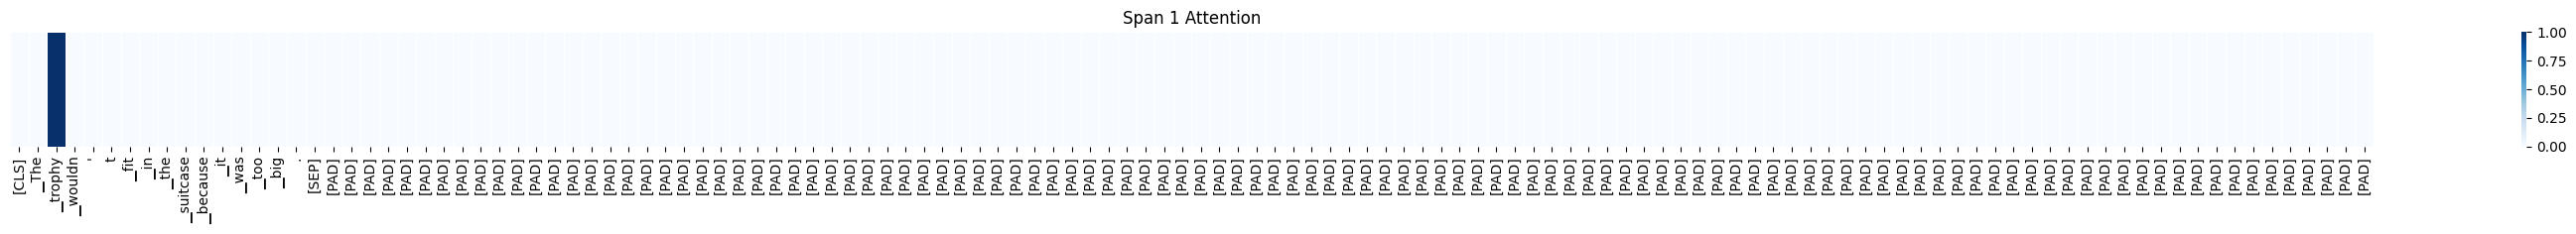

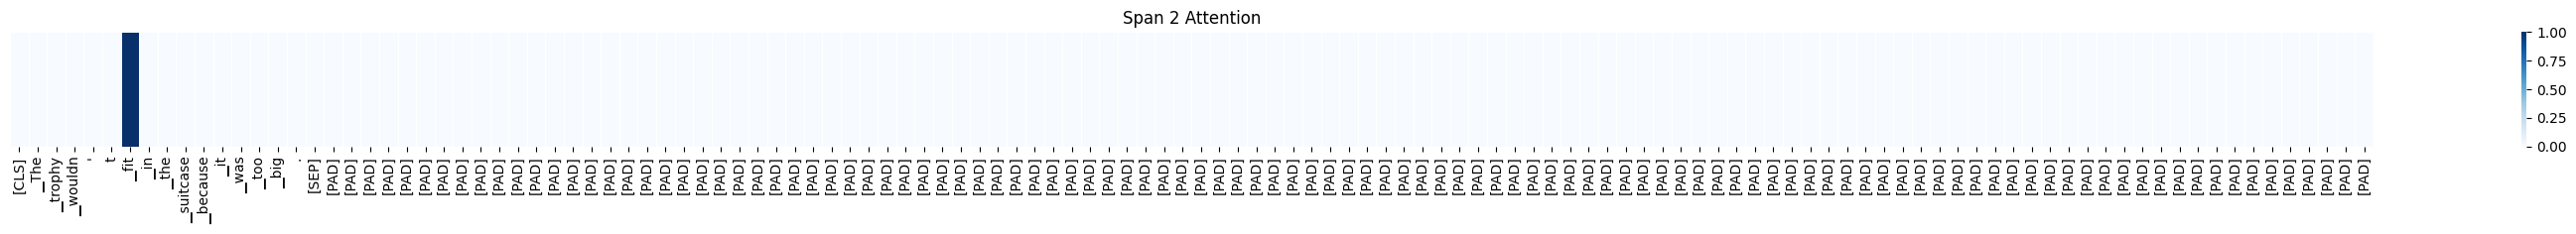

In [ ]:
# Load model if not already in memory
model.load_state_dict(torch.load('best_span_aware_wsc_model.pth', map_location=device))

# Example interactive prediction
predict_and_visualize(
    model=model,
    tokenizer=tokenizer,
    sentence="The trophy wouldn't fit in the suitcase because it was too big.",
    span1_text="trophy",
    span2_text="it",
    device=device
)


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset

# Load dataset and rename column
dataset = load_dataset("super_glue", "wsc.fixed")
dataset = dataset.rename_column("label", "labels")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("SpanBERT/spanbert-large-cased")

# Insert special markers
def insert_span_tokens(example):
    text = example["text"]
    span1_start = example["span1_index"]
    span2_start = example["span2_index"]
    span1 = example["span1_text"]
    span2 = example["span2_text"]

    if span1_start < span2_start:
        first, second = (span1_start, span1, "[SPAN1]", "[/SPAN1]"), (span2_start, span2, "[SPAN2]", "[/SPAN2]")
    else:
        first, second = (span2_start, span2, "[SPAN2]", "[/SPAN2]"), (span1_start, span1, "[SPAN1]", "[/SPAN1]")

    def insert(text, start, span, start_token, end_token):
        return text[:start] + start_token + span + end_token + text[start + len(span):]

    text = insert(text, first[0], first[1], first[2], first[3])
    text = insert(text, second[0] + len(first[2]) + len(first[3]), second[1], second[2], second[3])

    example["input_text"] = text
    return example

dataset = dataset.map(insert_span_tokens)

# Tokenize
def tokenize(example):
    return tokenizer(example["input_text"], truncation=True, padding="max_length", max_length=128)

tokenized_dataset = dataset.map(tokenize)


Map:   0%|          | 0/104 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("SpanBERT/spanbert-large-cased", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SpanBERT/spanbert-large-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score

training_args = TrainingArguments(
    output_dir="./spanbert_wsc",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()


/tmp/ipython-input-879229874.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: georgeokelloouma (georgeokelloouma-asia-pacific-university-of-technology-i) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.694300,0.663104,0.634615
2,0.705900,0.666031,0.634615
3,0.692700,0.685145,0.634615
4,0.694400,0.678953,0.634615


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


TrainOutput(global_step=280, training_loss=0.6944429891450065, metrics={'train_runtime': 635.9565, 'train_samples_per_second': 3.485, 'train_steps_per_second': 0.44, 'total_flos': 516289975283712.0, 'train_loss': 0.6944429891450065, 'epoch': 4.0})

In [ ]:
results = trainer.evaluate()
print(f"\n📊 Final Validation Accuracy: {results['eval_accuracy']*100:.2f}%")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



📊 Final Validation Accuracy: 63.46%


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import numpy as np

# Load model and tokenizer
model_name = "SpanBERT/spanbert-large-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Pick a few validation examples
samples = dataset["validation"].select(range(5))

def predict_and_print(example):
    encoded = tokenizer(example["input_text"], return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    with torch.no_grad():
        outputs = model(**encoded)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred = torch.argmax(probs, dim=-1).item()
        print(f"Text: {example['input_text']}")
        print(f"Prediction: {'Coreferent' if pred == 1 else 'Not coreferent'}")
        print(f"True Label: {'Coreferent' if example['labels'] == 1 else 'Not coreferent'}")
        print(f"Confidence: {probs[0][pred]:.4f}")
        print("-" * 80)

for ex in samples:
    predict_and_print(ex)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SpanBERT/spanbert-large-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Text: Bernard , who had not told the g[SPAN1]anyone[/SPAN1]ent offic[SPAN2]him[/SPAN2] that he was less than 21 when he filed for a homestead claim, did not consider that he had done anything dishonest. Still, anyone who knew that he was 19 years old could take his claim away from him .
Prediction: Not coreferent
True Label: Not coreferent
Confidence: 0.5299
--------------------------------------------------------------------------------
Text: [SPAN1]Mr. Moncrieff[/SPAN1] visited Chester 's luxuri[SPAN2]his[/SPAN2] New York apartment, thinking that it belonged to his son Edward . The result was that Mr. Moncrieff has decided to cancel Edward 's allowance on the ground that he no longer requires his financial support.
Prediction: Coreferent
True Label: Coreferent
Confidence: 0.5228
--------------------------------------------------------------------------------
Text: I tried to pa[SPAN1]lemon trees[[SPAN2]they[/SPAN2]N1]re of an orchard, with lemons in the lemon trees , but they came ou

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


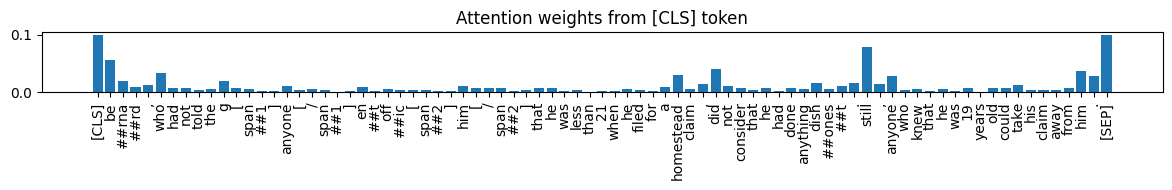

In [ ]:
def show_attention(model, tokenizer, text):
    # Tokenize and prepare inputs
    encoded = tokenizer(text, return_tensors="pt", return_attention_mask=True)
    tokens = tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])

    # Forward pass to extract attention
    model.eval()
    with torch.no_grad():
        outputs = model(**encoded, output_attentions=True)

    # Get attention from last layer, first head (CLS token to all)
    attentions = outputs.attentions[-1][0][0]  # shape: (seq_len, seq_len)
    cls_attention = attentions[0]  # CLS token

    # Plot attention weights
    plt.figure(figsize=(12, 2))
    plt.bar(range(len(tokens)), cls_attention)
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.title("Attention weights from [CLS] token")
    plt.tight_layout()
    plt.show()

# Example
sample_text = samples[0]["input_text"]
show_attention(model, tokenizer, sample_text)
